In [28]:
import os
import torch
import torchvision
import PIL.Image as Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [29]:
#direccion utilizada para los datasets de train y tests
train_dataset_path = 'C:/Users/eloy/Downloads/pajaros2/birds/birds'
test_dataset_path = 'C:/Users/eloy/Downloads/pajaros2/birds/birdsTest'



In [30]:
#desviacion tipica
mean = [0.4704, 0.4669, 0.3898]
#desviacion estandar
std = [0.2037, 0.2002, 0.2051]
#Estas son unas serie de transformaciones para transformarlas a 224 por 224 y ayudan a una mayor comprension de la red segun investigamos
train_transforms = transforms.Compose([
                                        transforms.Resize((224,224)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(10),
                                        transforms.ToTensor(),
                                        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))])

test_transforms = transforms.Compose([
                                        transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))])

In [31]:
#aqui se cran los datasets
train_dataset = torchvision.datasets.ImageFolder(root=train_dataset_path, transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root= test_dataset_path, transform=test_transforms)
#aqui los printeamos solo por curiosidad de ver la cantidad de imagenes
print(len(train_dataset))
print(len(test_dataset))

48788
9623


In [32]:
#definimos una funcion para ver la imagen transfomada
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle = True)
    batch = next(iter(loader))
    images, labels = batch
    
    
    grid = torchvision.utils.make_grid (images, nrow = 3)
    plt.figure(figsize = (11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


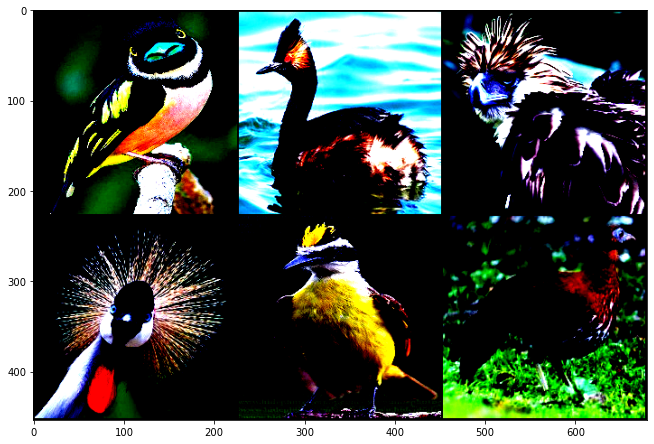

In [33]:
#aqui la enseñamos
show_transformed_images(test_dataset)

In [34]:
#creamos los loaders y tambien podemos cambiar los batch size 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)


In [35]:
#aqui configuramos el dispositivo utilizado en este modelo
def set_device():
    if torch.cuda.is_available():
        dev = 'cuda:0'
    else:
        dev = 'cpu'
    return torch.device(dev)

In [36]:
#definimoseste metodo para calcular el porcentaje de precision que tenemos
def evaluate_model(model, test_loader):
        model.eval()
        predicted_correctly_on_epoch = 0
        total = 0
        device = set_device()
        
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)
                total += labels.size(0)

                outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)

                predicted_correctly_on_epoch += (predicted == labels).sum().item()

        epoch_acc = 100.00 *predicted_correctly_on_epoch / total
        print('Testing dataset. Got %d out of %d images correctly (%.3f%%)'
             % (predicted_correctly_on_epoch, total, epoch_acc))
        return epoch_acc

In [37]:
#creamos el argoritmo de entreno a la red neuronal
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    
    best_acc = 0
    for epoch in range(n_epochs):
        print("Epoch number %d" % (epoch +1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0 
        total = 0
        
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_correct +=(labels==predicted).sum().item()
            
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 *running_correct / total
        
        print('Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f'
             % (running_correct, total, epoch_acc, epoch_loss))
        
        test_dataset_acc = evaluate_model(model, test_loader)
        
        if(test_dataset_acc > best_acc):
            best_acc = test_dataset_acc
            save_checkpoint(model, epoch, optimizer, best_acc)

            
        
    print("Train Finished")

    return model
        
            

In [38]:
#definimos para guardar el checkpoint
def save_checkpoint(model,epoch, optimizer, best_acc):
    state = {
        'epoch':epoch +1,
        'model': model.state_dict(),
        'best accuracy': best_acc,
        'optimizer' : optimizer.state_dict(),
    }
    torch.save(state, 'model_best_checkpoint.pth.tar')

In [39]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
#declaracion de un modelo preentrenado(resnet18)
resnet18_model = models.resnet18(pretrained = False)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 400
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet_18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr = 0.01, momentum=0.9, weight_decay=0.003)

In [40]:
#algoritmo de entreno el ultimo parametro es el utilizado para el numero de epocas
train_nn(resnet18_model,train_loader, test_loader, loss_fn, optimizer, 15)

Epoch number 1
Training dataset. Got 3575 out of 48788 images correctly (7.328%). Epoch loss: 4.801
Testing dataset. Got 969 out of 9623 images correctly (10.070%)
Epoch number 2
Training dataset. Got 13289 out of 48788 images correctly (27.238%). Epoch loss: 3.242
Testing dataset. Got 3157 out of 9623 images correctly (32.807%)
Epoch number 3
Training dataset. Got 21055 out of 48788 images correctly (43.156%). Epoch loss: 2.474
Testing dataset. Got 4095 out of 9623 images correctly (42.554%)
Epoch number 4
Training dataset. Got 25766 out of 48788 images correctly (52.812%). Epoch loss: 2.038
Testing dataset. Got 4920 out of 9623 images correctly (51.128%)
Epoch number 5
Training dataset. Got 28617 out of 48788 images correctly (58.656%). Epoch loss: 1.782
Testing dataset. Got 4963 out of 9623 images correctly (51.574%)
Epoch number 6
Training dataset. Got 30545 out of 48788 images correctly (62.608%). Epoch loss: 1.611
Testing dataset. Got 5563 out of 9623 images correctly (57.809%)
E

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
#utilizado para cargar un checkpoint
checkpoint = torch.load('model_best_checkpoint.pth.tar')

In [42]:
#mostramos informacion del checkpoint
print(checkpoint['epoch'])
print(checkpoint['best accuracy'])

12
68.59607191104645


In [43]:
#aqui guardamos el modelo solo hay que darle el path
model_path = 'C:/Users/eloy/Downloads/jupiter ia/modelo_seleccionado.pth'


resnet18_model = models.resnet18()
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 400
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
resnet18_model.load_state_dict(checkpoint['model'])

torch.save(resnet18_model, model_path)

In [53]:
#aqui cargamos el modelo solo hay que darle el path
model_path = 'C:/Users/eloy/Downloads/jupiter ia/modelo_seleccionado.pth'
model = torch.load(model_path)

In [54]:
#cargamos clases con el numero de clases para utilizarlo mas tarde se pude cambiar para coger la carpeta birds
clases_path = 'C:/Users/eloy/Downloads/pajaros2/birds/birds'
classes = os.listdir(clases_path)

In [55]:
#volvemos a crear un transformador para las imagenes de test
mean = [0.4704, 0.4669, 0.3898]
std = [0.2037, 0.2002, 0.2051]

image_transforms = transforms.Compose([
                                        transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))])


In [56]:
#se crea una pequeña funcion para clasificar todo los tests
def classify(model, image_transforms, image_path, classes):
    model = model.eval()
    image = Image.open(image_path)
    image = image_transforms(image).float()
    image = image.unsqueeze(0)
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    return classes[predicted.item()]

In [57]:
#se crea una lista de las imagenes de los tests que utilizamos 
#cambiar el path si es necesario utilizar otros tests
tests_path = 'C:/Users/eloy/Downloads/pajaros2/submission_test/submission_test'
a = os.listdir(tests_path)
print(len(a))
a.sort(key=len)
print(a)

2000
['391.jpg', '761.jpg', '1311.jpg', '1425.jpg', '1462.jpg', '1587.jpg', '3293.jpg', '3576.jpg', '4746.jpg', '5122.jpg', '6529.jpg', '7485.jpg', '8828.jpg', '9104.jpg', '9911.jpg', '9991.jpg', '10049.jpg', '11849.jpg', '12227.jpg', '12672.jpg', '12751.jpg', '12992.jpg', '13137.jpg', '13815.jpg', '14884.jpg', '14900.jpg', '15596.jpg', '16494.jpg', '16657.jpg', '17967.jpg', '18068.jpg', '18581.jpg', '18890.jpg', '20483.jpg', '20554.jpg', '20666.jpg', '21490.jpg', '24828.jpg', '25653.jpg', '27463.jpg', '28017.jpg', '28135.jpg', '28397.jpg', '29628.jpg', '30969.jpg', '34293.jpg', '35577.jpg', '35712.jpg', '38676.jpg', '39606.jpg', '39788.jpg', '40794.jpg', '43142.jpg', '44422.jpg', '45499.jpg', '46413.jpg', '48914.jpg', '52397.jpg', '52847.jpg', '53059.jpg', '56545.jpg', '57790.jpg', '60339.jpg', '61465.jpg', '61571.jpg', '61578.jpg', '62808.jpg', '64101.jpg', '66619.jpg', '67811.jpg', '71110.jpg', '71200.jpg', '71685.jpg', '71786.jpg', '72428.jpg', '72741.jpg', '73343.jpg', '74365.jpg'

In [58]:

import pandas as pd
import numpy as np
#aqui rellenamos dos listas una con la id de las imagenes y otra con la predicicion para esa imagen
x = 'Id , Category'
lista_Indice=[]
lista_Category=[]

tests2_path = 'C:/Users/eloy/Downloads/pajaros2/submission_test/submission_test/'
for i in a:
    l = i.split('.')[0]
    lista_Indice.append(l)
    lista_Category.append(classify(model, image_transforms, tests2_path+i ,classes))



In [59]:
#creamos dos arrays con las dos listas y una tabla con ellos que pasamos a csv
array_de =np.array([lista_Indice,lista_Category])
array_de2 =np.transpose(array_de)
print(array_de)
tabla = pd.DataFrame(data=array_de2 , columns=['Id','Category'])
tabla

[['391' '761' '1311' ... '19981965' '19991139' '19991200']
 ['ABBOTTS BABBLER' 'AMERICAN AVOCET' 'ABYSSINIAN GROUND HORNBILL' ...
  'WHITE THROATED BEE EATER' 'IBERIAN MAGPIE' 'JANDAYA PARAKEET']]


,Id,Category
0,391,ABBOTTS BABBLER
1,761,AMERICAN AVOCET
2,1311,ABYSSINIAN GROUND HORNBILL
3,1425,APAPANE
4,1462,CAPE GLOSSY STARLING
...,...,...
1995,19951251,LAZULI BUNTING
1996,19961923,VULTURINE GUINEAFOWL
1997,19981965,WHITE THROATED BEE EATER
1998,19991139,IBERIAN MAGPIE


In [60]:
#aqui transformamos la tabla a csv cambiar el path para guardar donde quieras
tabla_path = 'C:/Users/eloy/Downloads/jupiter ia/redneuronalcsv.csv'
tabla.to_csv(tabla_path,index=False)


In [52]:
#esto es utilizado para calcular desviacion tipica y estandar
#mean = [0.4704, 0.4669, 0.3898]
#std = [0.2037, 0.2002, 0.2051]

"""""
def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        print(images.shape)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        print(images.shape)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
        
    mean /= total_images_count
    std /= total_images_count
    
    return mean, std
"""""

'""\ndef get_mean_and_std(loader):\n    mean = 0.\n    std = 0.\n    total_images_count = 0\n    for images, _ in loader:\n        image_count_in_a_batch = images.size(0)\n        print(images.shape)\n        images = images.view(image_count_in_a_batch, images.size(1), -1)\n        print(images.shape)\n        mean += images.mean(2).sum(0)\n        std += images.std(2).sum(0)\n        total_images_count += image_count_in_a_batch\n        \n    mean /= total_images_count\n    std /= total_images_count\n    \n    return mean, std\n'

In [2]:
#get_mean_and_std(train_loader)

NameError: name 'train_loader' is not defined